# belief eye analysis

still behaivior analysis, but touching on what could be interesting


## imports

In [55]:
%reload_ext autoreload
%autoreload 2

In [56]:
import sys
import os
from pathlib import Path
import configparser
config = configparser.ConfigParser()
config.read_file(open('privateconfig'))
resdir = Path(config['Datafolder']['data'])
workdir = Path(config['Codefolder']['workspace'])
os.chdir(workdir)

In [57]:
# analysis
from scipy.io import loadmat
from sklearn.decomposition import FastICA
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.cross_decomposition import CCA

In [58]:
# misc
import pickle
from collections import defaultdict

In [59]:
from neural_plot_ult import *
import time
tic=time.time()
import warnings
warnings.filterwarnings('ignore')

# load data

In [60]:
df = pd.read_pickle(resdir/'0918_m51df.pkl')
len(df)
df=df[df.session==41]

In [61]:
def process_one(y):
    related_taskvar=np.array(normalize_z(y))
    mask=(related_taskvar > -4) & (related_taskvar < 4)
    related_taskvar[~mask]=0
    return related_taskvar, mask

def process(rawtaskvar, returnmask=False):
    # normalize each item to 0 mean 1 std
    rawtaskvar=[np.array(normalize_z(y)) for y in rawtaskvar]
    related_taskvar=np.vstack(rawtaskvar).T
    # related_taskvar=np.clip(related_taskvar,-4,4)
    mask=(related_taskvar > -4) & (related_taskvar < 4)
    mask=np.all(mask, axis=1)
    related_taskvar=related_taskvar[mask]
    if returnmask:
        return related_taskvar, mask
    return related_taskvar
def process_list(rawtaskvar, returnmask=False):
    # normalize each item to 0 mean 1 std
    rawtaskvar=[np.array(normalize_z(y)) for y in rawtaskvar]
    mask=[(a > -4) & (a < 4) for a in rawtaskvar]
    mask=np.all(mask)
    related_taskvar=[a[mask] for a in rawtaskvar]
    if returnmask:
        return related_taskvar, mask
    return related_taskvar

In [62]:
# error distribution
def get_stop_error(row):
    return ((row.fx[-1]-row.mx[-1])**2+(row.fy[-1]-row.my[-1])**2)**0.5
df['state_error']=df.apply(get_stop_error, axis=1)
def get_stop_error(row):
    return ((row.fx[-1]-row.bmx[-1])**2+(row.fy[-1]-row.bmy[-1])**2)**0.5
df['belief_error']=df.apply(get_stop_error, axis=1)

# time ratio
df['time_ratio']=df.apply(lambda x: x.timer/x.timer[-1], axis=1)


In [63]:
for session in sorted(df.session.unique())[:1]:
    sessdf=df[(df.session==session)]

state=np.concatenate(sessdf.belief_ff_hori.to_numpy())
belief=np.concatenate(sessdf.ff_hori.to_numpy())
eye=np.concatenate(sessdf.eye_hori.to_numpy())
timeratio=np.concatenate(sessdf.time_ratio.to_numpy())
timer=np.concatenate(sessdf.timer.to_numpy())
countdown=np.concatenate(sessdf.countdown.to_numpy())


In [64]:
# make a df by time (each row is a time, instead of a trial)
sessdf['density_t']=sessdf.apply(lambda x: np.array([[x.density]*len(x.mx)]).reshape(-1), axis=1)
sessdf['fullon_t']=sessdf.apply(lambda x: np.array([[x.fullon]*len(x.mx)]).reshape(-1), axis=1)
sessdf['error_t']=sessdf.apply(lambda x: np.array([[x.error]*len(x.mx)]).reshape(-1), axis=1)



timedf=pd.DataFrame({'timer':timer})
timedf['uncertainty']=list(np.concatenate(sessdf.relcov.to_numpy()))
timedf['belief']=np.concatenate(sessdf.belief_ff_hori.to_numpy())
timedf['state']=np.concatenate(sessdf.ff_hori.to_numpy())
timedf['eye']=np.concatenate(sessdf.eye_hori.to_numpy())
timedf['timeratio']=np.concatenate(sessdf.time_ratio.to_numpy())
timedf['mv']=np.concatenate(sessdf.mv.to_numpy())
timedf['mw']=np.concatenate(sessdf.mw.to_numpy())
timedf['belief_heading']=np.concatenate(sessdf.belief_heading.to_numpy())
timedf['timer']=np.concatenate(sessdf.timer.to_numpy())
timedf['countdown']=np.concatenate(sessdf.countdown.to_numpy())
timedf['belief_angle_from_start']=np.concatenate(sessdf.belief_angle_from_start.to_numpy())
timedf['PPC']=list(np.vstack(sessdf.PPC.to_numpy()))

timedf['density']=np.concatenate(sessdf.density_t.to_numpy())
timedf['fullon']=np.concatenate(sessdf.fullon_t.to_numpy())
timedf['error']=np.concatenate(sessdf.error_t.to_numpy())


timedf['dbelief']=np.concatenate(sessdf.apply(lambda x: np.diff(x.belief_ff_hori, prepend=x.belief_ff_hori[:1],axis=0),axis=1).to_numpy())
timedf['deye']=np.concatenate(sessdf.apply(lambda x: np.diff(x.eye_hori, prepend=x.eye_hori[:1],axis=0),axis=1).to_numpy())
timedf['dneural']=list(np.vstack(sessdf.apply(lambda x: np.diff(x.PPC, prepend=x.PPC[:1], axis=0),axis=1).to_numpy()))

timedf.head()
timedf = timedf.dropna(subset=['eye', 'state', 'belief'])

In [65]:
timedf.columns                                                           

Index(['timer', 'uncertainty', 'belief', 'state', 'eye', 'timeratio', 'mv',
       'mw', 'belief_heading', 'countdown', 'belief_angle_from_start', 'PPC',
       'density', 'fullon', 'error', 'dbelief', 'deye', 'dneural'],
      dtype='object')

# work

In [66]:
# when belief eye are different
'''seems the eye fixes and belief moves at begining of trial (from time ratio plots)
why? could be animal is not rational (did not pay attention) and irc still trys to explain. (irc assumes animla always see the target at begining)
or could be animal eye fix, moves and still thinking/update the belief.
evidence: mk moves. but eye does not.
    if pay attention, mk eye shoudl activly searching


if mk not paying attention. mk dos not see the target. those trials will have larger error and miss rate.
if mk is thinking, trials should have simlar error rate. mk see the target.
'''


'seems the eye fixes and belief moves at begining of trial (from time ratio plots)\nwhy? could be animal is not rational (did not pay attention) and irc still trys to explain. (irc assumes animla always see the target at begining)\nor could be animal eye fix, moves and still thinking/update the belief.\nevidence: mk moves. but eye does not.\n    if pay attention, mk eye shoudl activly searching\n\n\nif mk not paying attention. mk dos not see the target. those trials will have larger error and miss rate.\nif mk is thinking, trials should have simlar error rate. mk see the target.\n'

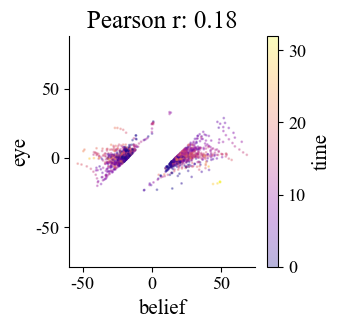

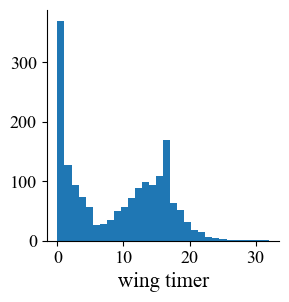

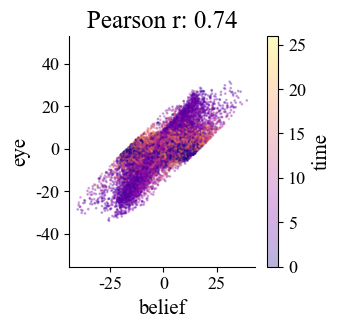

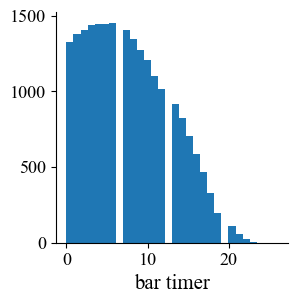

In [67]:
# when belief eye are different (try to seperate the x)
'''idea, there is a x when plot belief-eye scatter. 
can seperate the x by fitting the main bar (smaller err)
small wing has larger error
'''

aa,bb,cc=np.stack(timedf.belief.to_numpy()),np.stack(timedf.eye.to_numpy()),timedf.timer.to_numpy()
thisx,thisy,thisc=aa,bb,cc
thisx,thisy,thisc=np.array(thisx),np.array(thisy),np.array(thisc)
thisxname, thisyname, thiscname='belief', 'eye', 'time'

# mask the wing by eye and fit.
mask=(thisy<=-11)|(thisy>11)
# mask=(thisy>-11)&(thisy<11)
thisx,thisy,thisc=[a[mask] for a in [thisx,thisy,thisc]]
model = LinearRegression()
model.fit(thisx.reshape(-1,1),thisy.reshape(-1,1))

# fitting ---------------
# fig, ax = plt.subplots(figsize=(3,3))
# ax.scatter(thisx, thisy,c=thisc, s=1, alpha=0.3)
# slope=plot_best_fit(thisx, thisy, ax)
# # print(slope)
# r,_=pearsonr(thisx, thisy)
# ax.set_xlabel(f'belief')
# ax.set_ylabel(f'eye')
# ax.axis('equal')
# ax.set_title(f'Pearson r: {r:.2f}')


# bar 1 -----------------
thisx,thisy,thisc=aa,bb,cc
thisx,thisy,thisc=np.array(thisx),np.array(thisy),np.array(thisc)
thispred=model.predict(thisx.reshape(-1,1)).reshape(-1)
err=np.array(normalize_z((thisy-thispred)**2))
mask=err>1
thispred,thisy, thisc=thispred[mask],thisy[mask], thisc[mask]

fig, ax = plt.subplots(figsize=(3,3))
c=ax.scatter(thispred,thisy, c=thisc, cmap='plasma', s=1, alpha=0.3)
plt.colorbar(c, label=f'{thiscname}')
# slope=plot_best_fit(thispred,thisy, ax)
r,_=pearsonr(thispred,thisy)
ax.set_title(f'Pearson r: {r:.2f}')
ax.set_xlabel(f'{thisxname}')
ax.set_ylabel(f'{thisyname}')
ax.axis('equal')
plt.show()

fig, ax = plt.subplots(figsize=(3,3))
plt.hist(thisc, bins=30)
plt.xlabel('wing timer')
plt.show()

# bar 2 -----------------
thisx,thisy,thisc=aa,bb,cc
thisx,thisy,thisc=np.array(thisx),np.array(thisy),np.array(thisc)
thispred=model.predict(thisx.reshape(-1,1)).reshape(-1)
err=np.array(normalize_z((thisy-thispred)**2))
mask=err<1
thispred,thisy, thisc=thispred[mask],thisy[mask], thisc[mask]

fig, ax = plt.subplots(figsize=(3,3))
c=ax.scatter(thispred,thisy, c=thisc, cmap='plasma', s=1, alpha=0.3)
plt.colorbar(c, label=f'{thiscname}')
# slope=plot_best_fit(thispred,thisy, ax)
r,_=pearsonr(thispred,thisy)
ax.set_title(f'Pearson r: {r:.2f}')
ax.set_xlabel(f'{thisxname}')
ax.set_ylabel(f'{thisyname}')
ax.axis('equal')
plt.show()

fig, ax = plt.subplots(figsize=(3,3))
plt.hist(thisc, bins=30)
plt.xlabel('bar timer')
plt.show()



23140
(1862,)


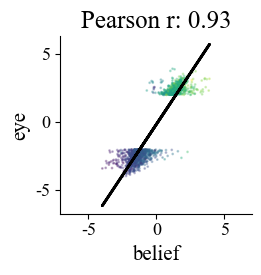

In [68]:


for session in sorted(df.session.unique())[:1]:
    sessdf=df[(df.session==session)]

    state=np.concatenate(sessdf.belief_ff_hori.to_numpy())
    belief=np.concatenate(sessdf.ff_hori.to_numpy())
    eye=np.concatenate(sessdf.eye_hori.to_numpy())
    
    related_taskvar = process([state, belief, eye])
    [state, belief, eye]=zip(*related_taskvar)
    
    maskvar=np.array(eye)
    mask=(maskvar<=-2)|(maskvar>2)
    print(len(eye))
    state, belief, eye=[np.array(a)[mask] for a in [state, belief, eye]]
    print(eye.shape)
    # related_taskvar = process([state, belief, eye])


    thisx, thisy, thisc=belief,eye,state
    
    fig, ax = plt.subplots(figsize=(3,3))
    ax.scatter(thisx, thisy,c=thisc, s=1, alpha=0.3)

    slope=plot_best_fit(thisx, thisy, ax)
    # print(slope)
    r,_=pearsonr(thisx, thisy)

    ax.set_xlabel(f'belief')
    ax.set_ylabel(f'eye')
    ax.axis('equal')
    ax.set_title(f'Pearson r: {r:.2f}')

    plt.tight_layout()

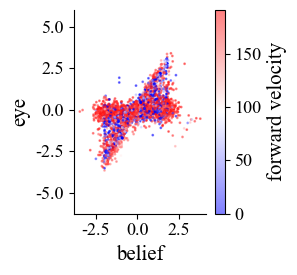

In [69]:
'''
actions at when belief eye differ
no pattern.
'''
for session in sorted(df.session.unique())[:1]:
    sessdf=df[(df.session==session)]

    state=np.concatenate(sessdf.belief_ff_hori.to_numpy())
    belief=np.concatenate(sessdf.ff_hori.to_numpy())
    eye=np.concatenate(sessdf.eye_hori.to_numpy())
    timer=np.concatenate(sessdf.time_ratio.to_numpy())
    mv=np.concatenate(sessdf.mv.to_numpy())
    mw=np.concatenate(sessdf.mw.to_numpy())
    
    related_taskvar, mask = process([state, belief, eye], returnmask=True)
    [state, belief, eye]=zip(*related_taskvar)
    timer=timer[mask]
    mv=mv[mask]
    mw=mw[mask]

    colorvar=mv
    maskvar=np.array(timer)
    mask=(maskvar<=0.2)&(maskvar>0)
    belief, eye, colorvar = [np.array(a)[mask] for a in [belief, eye, colorvar]]

    fig, ax = plt.subplots(figsize=(3,3))
    c=ax.scatter(belief,eye, c=colorvar, cmap='bwr', s=1, alpha=0.5)
    plt.colorbar(c, label='forward velocity')

    # slope=plot_best_fit(belief,eye, ax)
    # print(slope)
    # r,_=pearsonr(belief,eye)
    # ax.set_title(f'Pearson r: {r:.2f}')

    ax.set_xlabel(f'belief')
    ax.set_ylabel(f'eye')
    ax.axis('equal')

    plt.tight_layout()

# plots

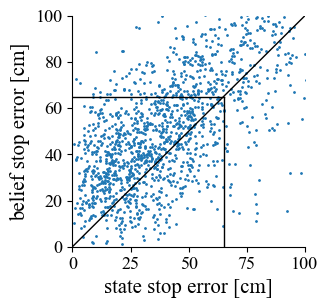

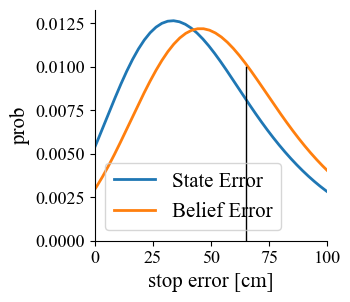

In [70]:
# state vs belief stop error
for session in sorted(df.session.unique()):
    sessdf=df[df.session==session]

    state_error=(sessdf.state_error.to_numpy())
    belief_error=(sessdf.belief_error.to_numpy())

    fig, ax = plt.subplots(1,1, figsize=(3,3))
    ax.scatter(state_error,belief_error, s=1, alpha=1)
    ax.plot([0,222],[0,222],color='black', linewidth=1)
    ax.plot([0,65],[65,65],color='black', linewidth=1)
    ax.plot([65,65],[65,0],color='black', linewidth=1)
    ax.set_xlim(0,100)
    ax.set_ylim(0,100)
    ax.set_xlabel('state stop error [cm]')
    ax.set_ylabel('belief stop error [cm]')
    # ax.axis('equal')
    quickspine(ax)
    fig.show()

    fig, ax = plt.subplots(1,1, figsize=(3,3))
    sns.kdeplot(state_error, ax=ax, label='State Error',bw=0.5)
    sns.kdeplot(belief_error, ax=ax, label='Belief Error',bw=0.5)
    ax.plot([65,65],[0.01,0],color='black', linewidth=1)
    ax.set_xlabel('stop error [cm]')
    ax.set_ylabel('prob')
    ax.set_xlim(0,100)
    ax.legend()
    quickspine(ax)
    fig.show()

  

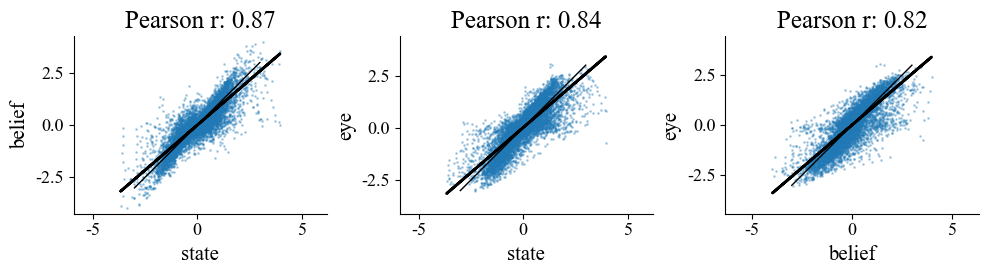

In [71]:
# state, eye, belief corr (masked by time ratio)

for session in sorted(df.session.unique())[:1]:
    sessdf=df[(df.session==session)]

    state=np.concatenate(sessdf.belief_ff_hori.to_numpy())
    belief=np.concatenate(sessdf.ff_hori.to_numpy())
    eye=np.concatenate(sessdf.eye_hori.to_numpy())
    
    maskvar=np.concatenate(sessdf.time_ratio.to_numpy())
    mask=(maskvar<=0.6) & (maskvar>0.2)
    [state, belief, eye]=[a[mask] for a in [state, belief, eye]]
    related_taskvar = process([state, belief, eye])
    
    fig, axs = plt.subplots(1,3, figsize=(10,3))
    names=['state','belief','eye']
    k=0
    for i in range(3):
        for j in range(i+1,3):
            axs[k].scatter(related_taskvar[:,i], related_taskvar[:,j], s=1, alpha=0.3)
            axs[k].plot([-3,3],[-3,3],color='black', linewidth=1)
            
            plot_best_fit(related_taskvar[:,i], related_taskvar[:,j], axs[k])
            # quickallspine(ax)
            ax.axis('equal')
            r,_=pearsonr(related_taskvar[:,i], related_taskvar[:,j])

            axs[k].set_xlabel(f'{names[i]}')
            axs[k].set_ylabel(f'{names[j]}')
            axs[k].axis('equal')
            axs[k].set_title(f'Pearson r: {r:.2f}')
            k+=1
    plt.tight_layout()

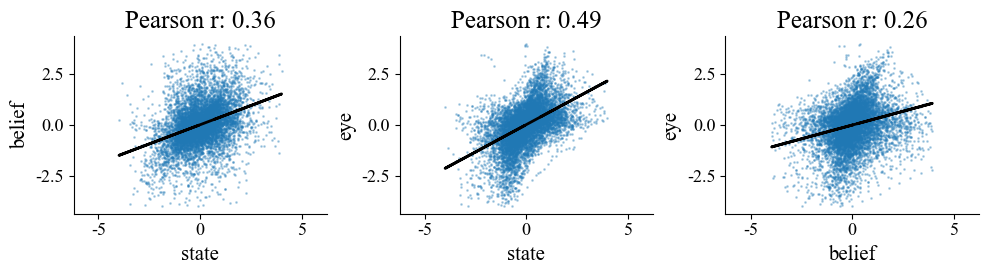

In [72]:
# state, eye, belief corr (masked by time)

for session in sorted(df.session.unique())[:1]:
    sessdf=df[(df.session==session)]

    state=np.concatenate(sessdf.belief_ff_hori.to_numpy())
    belief=np.concatenate(sessdf.ff_hori.to_numpy())
    eye=np.concatenate(sessdf.eye_hori.to_numpy())
    
    markvar=np.concatenate(sessdf.timer.to_numpy())
    mask=(markvar>7)
    [state, belief, eye]=[a[mask] for a in [state, belief, eye]]

    related_taskvar = process([state, belief, eye])
    
    fig, axs = plt.subplots(1,3, figsize=(10,3))
    names=['state','belief','eye']
    k=0
    for i in range(3):
        for j in range(i+1,3):
            axs[k].scatter(related_taskvar[:,i], related_taskvar[:,j], s=1, alpha=0.3)
            # axs[k].plot([-3,3],[-3,3],color='black', linewidth=1)
            
            plot_best_fit(related_taskvar[:,i], related_taskvar[:,j], axs[k])
            # quickallspine(ax)
            ax.axis('equal')
            r,_=pearsonr(related_taskvar[:,i], related_taskvar[:,j])

            axs[k].set_xlabel(f'{names[i]}')
            axs[k].set_ylabel(f'{names[j]}')
            axs[k].axis('equal')
            axs[k].set_title(f'Pearson r: {r:.2f}')
            k+=1
    plt.tight_layout()

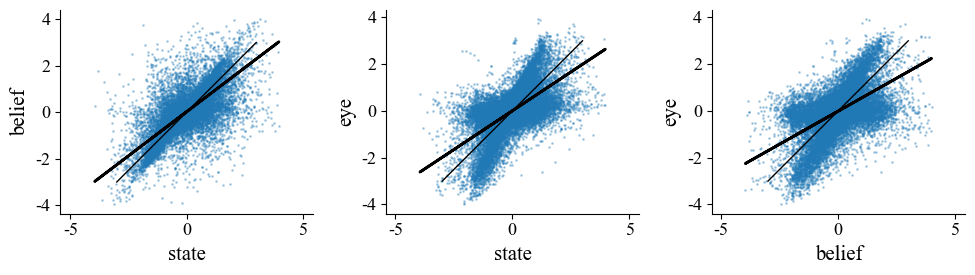

In [73]:
# state, eye, belief corr
for session in sorted(df.session.unique()):
    sessdf=df[df.session==session]

    state=np.concatenate(sessdf.belief_ff_hori.to_numpy())
    belief=np.concatenate(sessdf.ff_hori.to_numpy())
    eye=np.concatenate(sessdf.eye_hori.to_numpy())

    related_taskvar = process([state, belief, eye])
    
    fig, axs = plt.subplots(1,3, figsize=(10,3))
    names=['state','belief','eye']
    k=0
    for i in range(3):
        for j in range(i+1,3):
            axs[k].scatter(related_taskvar[:,i], related_taskvar[:,j], s=1, alpha=0.3)
            axs[k].plot([-3,3],[-3,3],color='black', linewidth=1)
            s=plot_best_fit(related_taskvar[:,i], related_taskvar[:,j], axs[k])
            axs[k].set_xlabel(f'{names[i]}')
            axs[k].set_ylabel(f'{names[j]}')
            axs[k].axis('equal')
            k+=1
    plt.tight_layout()

Text(0.5, 0.98, 'not full on')

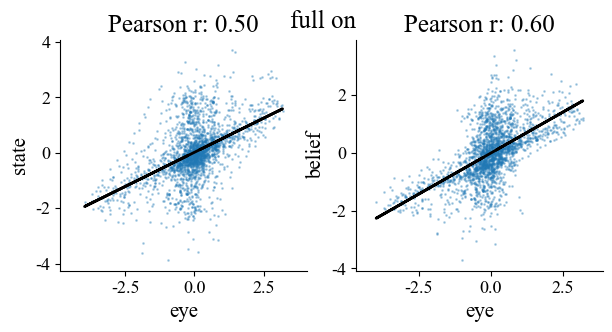

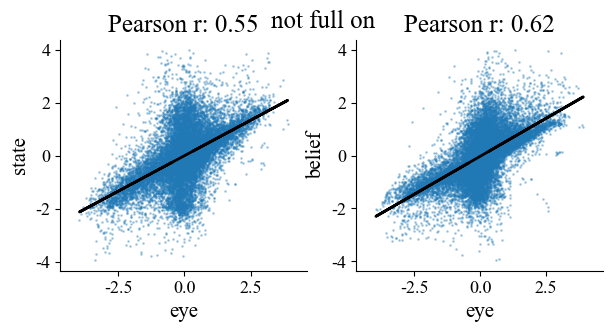

In [74]:
# correlation scatter
sessdf=df[df.fullon==1]

# state=np.concatenate(sessdf.heading.to_numpy())
# belief=np.concatenate(sessdf.belief_heading.to_numpy())
state=np.concatenate(sessdf.ff_hori.to_numpy())
belief=np.concatenate(sessdf.belief_ff_hori.to_numpy())
eye=np.concatenate(sessdf.eye_hori.to_numpy())

mask=state!=0
state,belief,eye=state[mask],belief[mask],eye[mask]
related_taskvar = process([state, belief, eye])
names=['state', 'belief']
fig, axs = plt.subplots(1,2, figsize=(7,3))
for i in range(2):
    axs[i].scatter(related_taskvar[:,2], related_taskvar[:,i], s=1, alpha=0.3)
    # axs[i].plot([-3,3],[-3,3],color='black', linewidth=1)

    plot_best_fit(related_taskvar[:,2], related_taskvar[:,i],axs[i])

    axs[i].set_xlabel(f'eye')
    axs[i].set_ylabel(f'{names[i]}')
    axs[i].axis('equal')
    r,_=pearsonr(related_taskvar[:,i], related_taskvar[:,j])
    axs[i].set_title(f'Pearson r: {r:.2f}')
    k+=1
plt.suptitle('full on')

sessdf=df[df.fullon==0]
# state=np.concatenate(sessdf.heading.to_numpy())
# belief=np.concatenate(sessdf.belief_heading.to_numpy())
state=np.concatenate(sessdf.ff_hori.to_numpy())
belief=np.concatenate(sessdf.belief_ff_hori.to_numpy())
eye=np.concatenate(sessdf.eye_hori.to_numpy())

mask=state!=0
state,belief,eye=state[mask],belief[mask],eye[mask]
related_taskvar = process([state, belief, eye])
names=['state', 'belief']
fig, axs = plt.subplots(1,2, figsize=(7,3))
for i in range(2):
    axs[i].scatter(related_taskvar[:,2], related_taskvar[:,i], s=1, alpha=0.3)
    # axs[i].plot([-3,3],[-3,3],color='black', linewidth=1)

    plot_best_fit(related_taskvar[:,2], related_taskvar[:,i],axs[i])

    axs[i].set_xlabel(f'eye')
    axs[i].set_ylabel(f'{names[i]}')
    axs[i].axis('equal')
    r,_=pearsonr(related_taskvar[:,i], related_taskvar[:,j])
    axs[i].set_title(f'Pearson r: {r:.2f}')
    k+=1
plt.suptitle('not full on')

Text(0.5, 0.98, 'not full on')

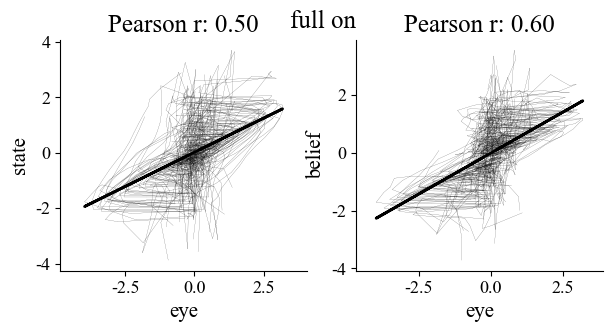

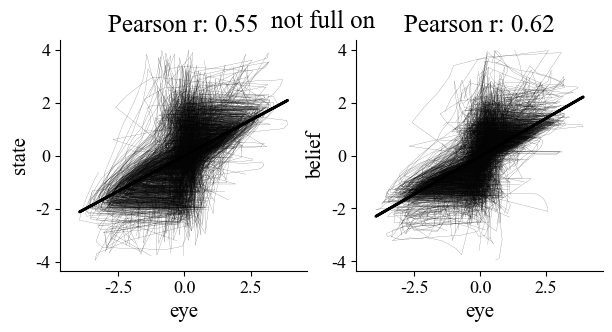

In [75]:
sessdf=df[df.fullon==1]
state=np.concatenate(sessdf.ff_hori.to_numpy())
belief=np.concatenate(sessdf.belief_ff_hori.to_numpy())
eye=np.concatenate(sessdf.eye_hori.to_numpy())
timer=np.concatenate(sessdf.time_ratio.to_numpy())
mask=state!=0
state,belief,eye=state[mask],belief[mask],eye[mask]
timer=timer[mask]
related_taskvar, mask = process([state, belief, eye], returnmask=True)
timer=timer[mask]
names=['state', 'belief']
fig, axs = plt.subplots(1,2, figsize=(7,3))
for i in range(2):

    for j in range(len(related_taskvar)-1):
        if timer[j]!=1:
            axs[i].plot([related_taskvar[j,2],related_taskvar[j+1,2]], [related_taskvar[j,i],related_taskvar[j+1,i]], linewidth=0.1, color='black')

    
    plot_best_fit(related_taskvar[:,2], related_taskvar[:,i],axs[i])
    axs[i].set_xlabel(f'eye')
    axs[i].set_ylabel(f'{names[i]}')
    axs[i].axis('equal')
    r,_=pearsonr(related_taskvar[:,i], related_taskvar[:,2])
    axs[i].set_title(f'Pearson r: {r:.2f}')
    k+=1
plt.suptitle('full on')

sessdf=df[df.fullon==0]
state=np.concatenate(sessdf.ff_hori.to_numpy())
belief=np.concatenate(sessdf.belief_ff_hori.to_numpy())
eye=np.concatenate(sessdf.eye_hori.to_numpy())
timer=np.concatenate(sessdf.time_ratio.to_numpy())
mask=state!=0
state,belief,eye=state[mask],belief[mask],eye[mask]
timer=timer[mask]
related_taskvar, mask = process([state, belief, eye], returnmask=True)
timer=timer[mask]
names=['state', 'belief']
fig, axs = plt.subplots(1,2, figsize=(7,3))
for i in range(2):

    for j in range(len(related_taskvar)-1):
        if timer[j]!=1:
            axs[i].plot([related_taskvar[j,2],related_taskvar[j+1,2]], [related_taskvar[j,i],related_taskvar[j+1,i]], linewidth=0.1, color='black')

    
    plot_best_fit(related_taskvar[:,2], related_taskvar[:,i],axs[i])
    axs[i].set_xlabel(f'eye')
    axs[i].set_ylabel(f'{names[i]}')
    axs[i].axis('equal')
    r,_=pearsonr(related_taskvar[:,i], related_taskvar[:,2])
    axs[i].set_title(f'Pearson r: {r:.2f}')
    k+=1
plt.suptitle('not full on')

Text(0.5, 0.98, 'full on, all data')

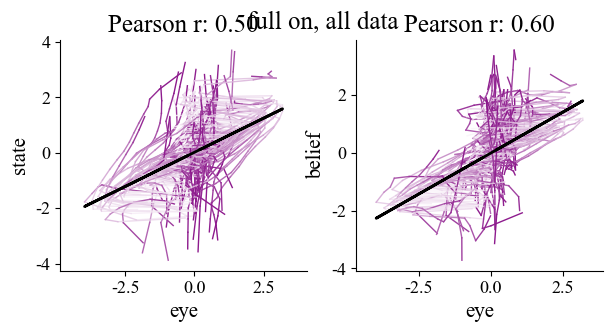

In [76]:
sessdf=df[(df.fullon==1)]
state=np.concatenate(sessdf.ff_hori.to_numpy())
belief=np.concatenate(sessdf.belief_ff_hori.to_numpy())
eye=np.concatenate(sessdf.eye_hori.to_numpy())
timer=np.concatenate(sessdf.time_ratio.to_numpy())
mask=state!=0
state,belief,eye=state[mask],belief[mask],eye[mask]
timer=timer[mask]
related_taskvar, mask = process([state, belief, eye], returnmask=True)
timer=timer[mask]
names=['state', 'belief']
fig, axs = plt.subplots(1,2, figsize=(7,3))
for i in range(2):
    s=0
    while s<len(related_taskvar):
        e=s+1
        while e<len(related_taskvar) and timer[e]!=0:
            e+=1
        # print(s,e)
        plot_gradient_line(axs[i], related_taskvar[s:e,2], related_taskvar[s:e,i], cmap=cmap_belief, linewidth=1)
        s=e
    
    plot_best_fit(related_taskvar[:,2], related_taskvar[:,i],axs[i])
    axs[i].set_xlabel(f'eye')
    axs[i].set_ylabel(f'{names[i]}')
    axs[i].axis('equal')
    r,_=pearsonr(related_taskvar[:,i], related_taskvar[:,2])
    axs[i].set_title(f'Pearson r: {r:.2f}')
    k+=1
plt.suptitle('full on, all data')

Text(0.5, 0.98, 'full on')

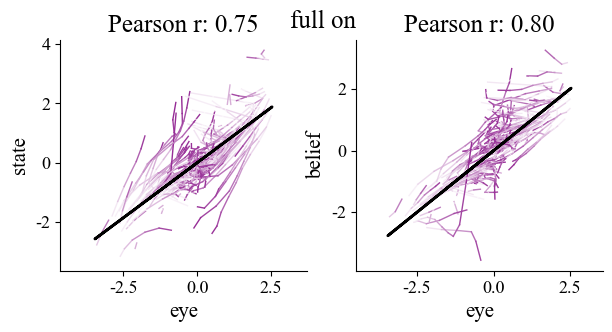

In [77]:
thisdf=timedf[(timedf.fullon==1)&((timedf.timeratio<0.7)&(timedf.timeratio>0.2))]
state=thisdf.state.to_numpy()
belief=thisdf.belief.to_numpy()
eye=thisdf.eye.to_numpy()
timer=thisdf.timeratio.to_numpy()

related_taskvar, mask = process([state, belief, eye], returnmask=True)
timer=timer[mask]
names=['state', 'belief']
fig, axs = plt.subplots(1,2, figsize=(7,3))
for i in range(2):
    s=0
    while s<len(related_taskvar):
        e=s+1
        while e<len(related_taskvar) and timer[e]>timer[e-1]:
            e+=1
        e-1
        # print(s,e, timer[s], timer[e])
        plot_gradient_line(axs[i], related_taskvar[s:e,2], related_taskvar[s:e,i], cmap=cmap_belief, linewidth=1)
        s=e
    
    plot_best_fit(related_taskvar[:,2], related_taskvar[:,i],axs[i])
    axs[i].set_xlabel(f'eye')
    axs[i].set_ylabel(f'{names[i]}')
    axs[i].axis('equal')
    r,_=pearsonr(related_taskvar[:,i], related_taskvar[:,2])
    axs[i].set_title(f'Pearson r: {r:.2f}')
    k+=1
plt.suptitle('full on')

Text(0.5, 0.98, 'not full on')

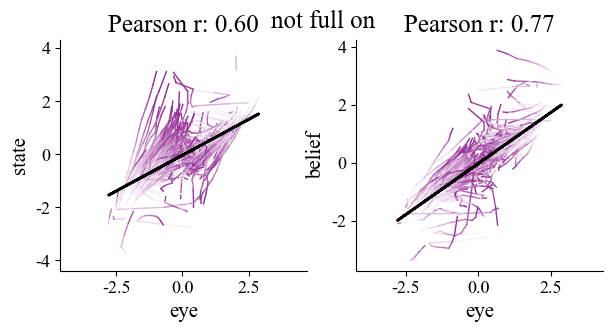

In [78]:
thisdf=timedf[(timedf.fullon==0)&((timedf.timeratio<0.7)&(timedf.timeratio>0.2))&(timedf.error>65)]
state=thisdf.state.to_numpy()
belief=thisdf.belief.to_numpy()
eye=thisdf.eye.to_numpy()
timer=thisdf.timeratio.to_numpy()

related_taskvar, mask = process([state, belief, eye], returnmask=True)
timer=timer[mask]
names=['state', 'belief']
fig, axs = plt.subplots(1,2, figsize=(7,3))
for i in range(2):
    s=0
    while s<len(related_taskvar):
        e=s+1
        while e<len(related_taskvar) and timer[e]>timer[e-1]:
            e+=1
        e-1
        # print(s,e, timer[s], timer[e])
        plot_gradient_line(axs[i], related_taskvar[s:e,2], related_taskvar[s:e,i], cmap=cmap_belief, linewidth=1)
        s=e
    
    plot_best_fit(related_taskvar[:,2], related_taskvar[:,i],axs[i])
    axs[i].set_xlabel(f'eye')
    axs[i].set_ylabel(f'{names[i]}')
    axs[i].axis('equal')
    r,_=pearsonr(related_taskvar[:,i], related_taskvar[:,2])
    axs[i].set_title(f'Pearson r: {r:.2f}')
    k+=1
plt.suptitle('not full on')